In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import folium
import webbrowser
from folium.plugins import HeatMap
import os
import time
import datetime

def file_name( user_dir):
        file_list = list()
        for root, dirs, files in os.walk(user_dir):
            for file in files:
                # if os.path.splitext(file)[1] == '.txt':
                if file.split('.')[-1]=='csv':
                    file_list.append(os.path.join(root, file))
        return file_list

path="car"     #此处的路径为存放excel的根目录
csv=file_name(path)         #得到一个列表，里面为10个excel的存放地址

data=pd.read_csv(csv[0])

以第一个文件为例，分析其加速度、角加速度。在计算前需要将GPS值转换为实际距离，即将经纬度转换为两点距离

In [2]:
def composeTime(time1):
    time2 = datetime.datetime.strptime(time1, "%Y-%m-%d %H:%M:%S")
    time3 = time.mktime(time2.timetuple())
    time4 = int(time3)
    return time4

def hypot(x,y):
    return math.sqrt(x**2+y**2)

def distance(lat1, lon1, lat2, lon2):
    PI = 3.1415926535898
    R = 6.371229 * 1e6
    x = (lon2 - lon1) * PI * R * math.cos( ( (lat1 + lat2) / 2) * PI / 180) / 180
    y = (lat2 - lat1) * PI * R / 180
    out = hypot(x, y)
    return out

计算前后两条记录数据的时间间隔小于100的数据数量

In [11]:
import matplotlib.pyplot as plt
import time
import datetime
T=[]
for i in range(len(data["location_time"])-1):
    t1 = composeTime(data["location_time"][i])
    t2 = composeTime(data["location_time"][i+1])
    if t2-t1<100:
        T.append(t2-t1)
count1=0
count2=0
count3=0
for i in range(len(T)):
    if T[i]==1:
        count1=count1+1
    elif T[i]==2:
        count2=count2+1
    else:
        count3=count3+1
print("时间间隔为1s ：",count1)
print("时间间隔为2s ：",count2)
print("时间间隔大于2s 小于100s ：",count3)
print(count1+count2+count3==len(data["location_time"]))
print("时间间隔大于100s ：",len(data["location_time"])-(count1+count2+count3))

时间间隔为1s ： 59613
时间间隔为2s ： 794
时间间隔大于2s 小于100s ： 24
False
时间间隔大于100s ： 12


计算加速度：两条数据的时间间隔单位为秒，速度单位为km/h，需要对速度单位进行转化（除以3.6）.汽车设备存在偶然的延时记录或断开链接，此处将时间间隔大于100s的数据视为不准确数据，因此计算加速度时不考虑该数据（根据上述计算，大于100s的数据为12份）

In [12]:
import matplotlib.pyplot as plt    
import time
import datetime
import numba as nb
import math
T=[]
a=[]

for i in range(len(data["gps_speed"])-1):
    t1 = composeTime(data["location_time"][i])
    t2 = composeTime(data["location_time"][i+1])
    v1=data["gps_speed"][i]/3.6
    v2=data["gps_speed"][i+1]/3.6
    if t2-t1<100:
        a.append((v2-v1)/(t2-t1))
count_2=0
count_4=0
count_6=0
for i in  range(len(a)):
    if math.fabs(a[i])<2:
        count_2=count_2+1
    elif math.fabs(a[i])>2 and math.fabs(a[i])<4:
        count_4=count_4+1
    else :
        count_6=count_6+1

print("加速度小于2m/s :",count_2)
print("加速度为2m/s < a <4m/s :",count_4)
print("加速度大于4m/s :",count_6)

加速度小于2m/s : 59878
加速度为2m/s < a <4m/s : 535
加速度大于4m/s : 18


计算角加速度：急转弯时间间隔考虑为1000s以下；值得注意的是，掉头和非掉头的计算方式不一样；图片保存至文件夹

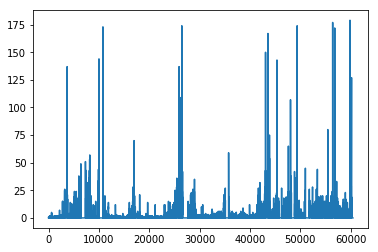

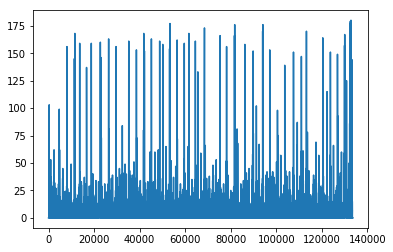

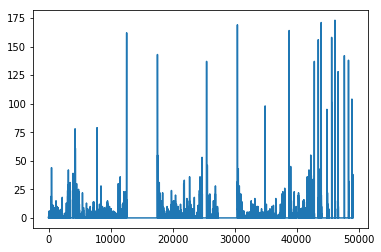

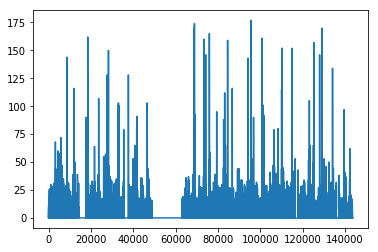

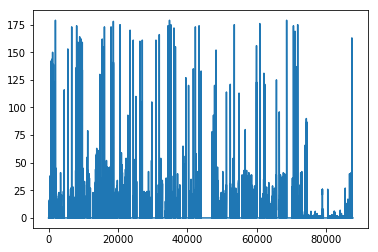

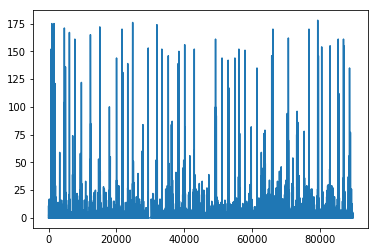

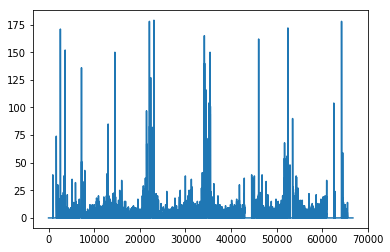

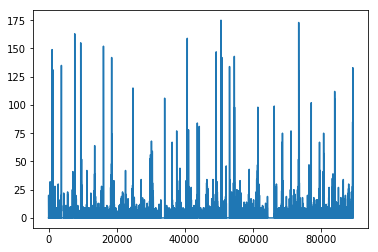

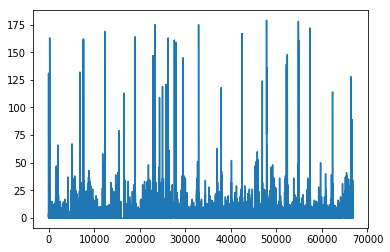

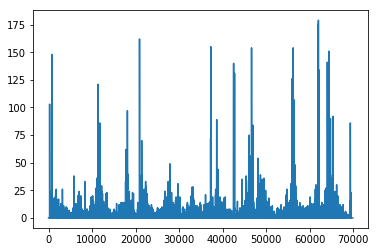

In [15]:
import numpy as np                #che su wending xing
import pandas as pd
import seaborn as sns
import folium
import webbrowser
from folium.plugins import HeatMap
import os
import time
import datetime
import matplotlib.pyplot as plt
import math
import numba as nb
def composeTime(time1):
    time2 = datetime.datetime.strptime(time1, "%Y-%m-%d %H:%M:%S")
    time3 = time.mktime(time2.timetuple())
    time4 = int(time3)
    return time4
def file_name( user_dir):
        file_list = list()
        for root, dirs, files in os.walk(user_dir):
            for file in files:
                # if os.path.splitext(file)[1] == '.txt':
                if file.split('.')[-1]=='csv':
                    file_list.append(os.path.join(root, file))
        return file_list
path="car" 
csv=file_name(path)

for j in range(len(csv)):        #计算角加速度
    w=[]   
    data=pd.read_csv(csv[j])
    for i in range(len(data["gps_speed"])-1):
        t1 = composeTime(data["location_time"][i])
        t2 = composeTime(data["location_time"][i+1])
        angle1=data["direction_angle"][i]
        angle2=data["direction_angle"][i+1]
        if t2-t1<1000 and t2-t1>0:                   #急转弯时间间隔考虑为1000s以下
            if math.fabs(angle2-angle1) > 180:
                w0=(360-math.fabs(angle2-angle1))/(t2-t1)
                w0=w0/(t2-t1)
                w.append(w0)
            else:
                w0=math.fabs(angle2-angle1)/(t2-t1)
                w0=w0/(t2-t1)
                w.append(w0)
    plt.figure()
    plt.plot(w)
    name=csv[j].split(",")[0].split("\\")[-1]
    plt.savefig(r'car/angle/'+name+".jpg")

以第一个文档为例，绘制停车时间（此处是指，发动机开启但是速度为0时的停车时长）——怠速运行时长图

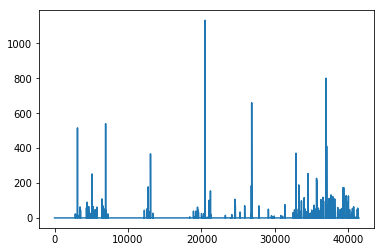

In [17]:
import math
import matplotlib.pyplot as plt
import time
import datetime

data=pd.read_csv(csv[0])
stop_car=[]  
count=0
for i in range(len(data["gps_speed"])-1):
    t1 = composeTime(data["location_time"][i])
    t2 = composeTime(data["location_time"][i+1])
    if data["acc_state"][i]== True:
        if data["gps_speed"][i]==0:
            count=count+(t2-t1)
        else:
            stop_car.append(count)
            count=0
    elif data["acc_state"][i]== False:
        count=0
plt.plot(stop_car)

以第一个文档为例，绘制加速度情况：正向和反向；可以看出急加速和急减速情况

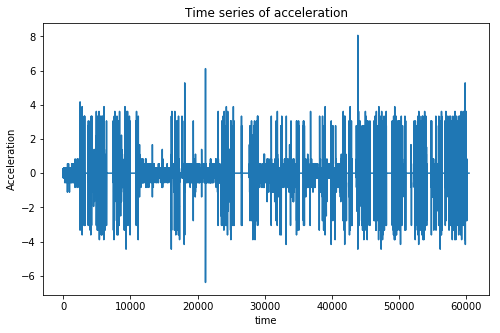

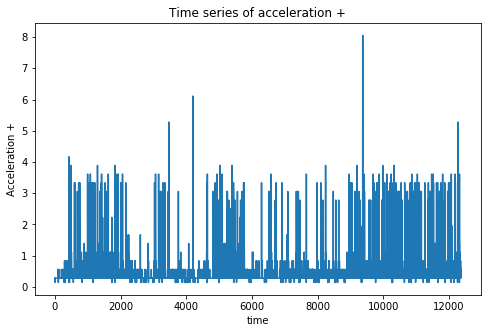

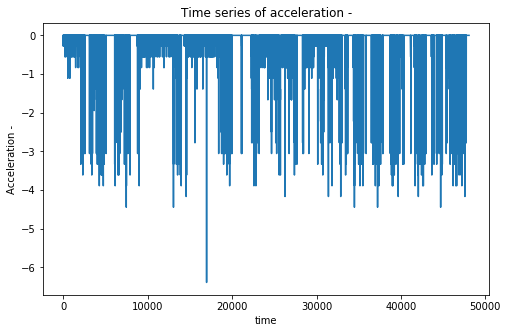

In [19]:
import matplotlib.pyplot as plt    #jia sudu
import time
import datetime
import pandas as pd

data1=pd.read_csv(csv[0])
T=[]
a=[]
a_jia=[]
a_jian=[]
v=[]
for i in range(len(data1["gps_speed"])-1):
    t1 = composeTime(data1["location_time"][i])
    t2 = composeTime(data1["location_time"][i+1])
    v1=data1["gps_speed"][i]/3.6
    v2=data1["gps_speed"][i+1]/3.6
    if t2-t1<100 :
        g=(v2-v1)/(t2-t1)
        a.append(g)
        v.append(v2)
        if g>0:
             a_jia.append(g)
        else:
             a_jian.append(g)
plt.figure(figsize=(8,5))
plt.plot(a)
plt.xlabel('time')
plt.ylabel("Acceleration")
plt.title('Time series of acceleration')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(a_jia)
plt.xlabel('time')
plt.ylabel("Acceleration +")
plt.title('Time series of acceleration +')
plt.show()

plt.figure(figsize=(8,5))
plt.plot(a_jian)
plt.xlabel('time')
plt.ylabel("Acceleration -")
plt.title('Time series of acceleration -')
plt.show()